## Document Analyzer

Using an **agentic approach** the complex task is divided between focused agents.

Features:
* provide a summary of the doc
* identify spelling and grammar errors
* analyze clarity, defined goals
* anonimyze the result

In [1]:
import re
from pydantic import BaseModel, Field
from typing_extensions import Literal, TypedDict
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown
import pdfplumber

from oci_models import create_model_for_answer_directly
from utils import get_console_logger

In [2]:
#
# Helper functions
#
def extract_file_name(text):
    match = re.search(r'```(.*?)```', text)
    if match:
        return match.group(1)  
    return None

def read_pdf(file_name):
    testo = ""
    with pdfplumber.open(file_name) as pdf:
        for pagina in pdf.pages:
            testo += pagina.extract_text() + "\n"
    return testo

In [3]:
logger = get_console_logger()

# here we create the LLM. A single LLM is used
# but, if needed, every tool can use a different LLM.
# Every tool has a dedicated, focused prompt
llm = create_model_for_answer_directly()

In [4]:
# Graph state
class State(TypedDict):
    request: str
    file_name: str
    file_text: str

    # output for single tools
    output1: str
    output2: str
    output3: str
    output4: str
    # output from aggregator
    combined_output: str
    
    final_output: str

# Nodes
def call_llm_0(state: State):
    """
    Extract the file name and read it
    """
    PROMPT = """
    Analyze the user's request and extract only the file name.
    Provide only the file name enclosed in triple backtick.
    """
    logger.info("Calling llm_0...")

    messages = [SystemMessage(content=PROMPT),
               HumanMessage(content=state["request"])]
    
    result = llm.invoke(input=messages)

    f_name = extract_file_name(result.content)
    logger.info(f"File name to be analyzed is: {f_name}")
    
    logger.info("Reading file content...")
    file_text = read_pdf(f_name)
    
    return {"file_name": f_name, "file_text": file_text}
    
def call_llm_1(state: State):
    """First LLM call to generate spelling errors list"""
    TOP_E = 10
    
    logger.info("Calling llm_1 to identify spelling errors...")

    request = f"Identify top {TOP_E} spelling errors in the following text: {state['file_text']}"
    msg = llm.invoke(request)
    
    return {"output1": msg.content}

def call_llm_2(state: State):
    """Second LLM call to analyze clarity"""

    logger.info("Calling llm_2 to analyze clarity...")
    
    request = f"""Evaluate from the point of view of clarity the following text: {state['file_text']}.
    Provide a score ranging from 1 to 10 (10 is best).
    """
    
    msg = llm.invoke(request)
    
    return {"output2": msg.content}

def call_llm_3(state: State):
    """Third LLM call to analyze goals"""

    logger.info("Calling llm_3 to analyze goals...")
    
    request = f"""Evaluate the following text: {state['file_text']}.
    Check that it defines clear and measurable goals.
    Provide a score ranging from 1 to 10 (10 is best).
    """
    
    msg = llm.invoke(request)
    
    return {"output3": msg.content}

def call_llm_4(state: State):
    """Fourth LLM call to summarize"""

    logger.info("Calling llm_4 to summarize...")
    
    request = f"""Summarize the following text in one page: {state['file_text']}.
    """
    
    msg = llm.invoke(request)
    
    return {"output4": msg.content}
    
def aggregator(state: State):
    """Combine all the outputs from steps into a single output"""

    logger.info("Aggregating outputs...")

    # here we can add whatever logic we want,
    combined = f"## Analysis of the document: {state['file_name']}\n\n"
    combined += f"### Summary:\n{state['output4']}\n\n"
    combined += f"### Clarity:\n{state['output2']}\n\n"
    combined += f"### Goals:\n{state['output3']}\n\n"
    combined += f"### Spelling errors:\n{state['output1']}\n\n"

    return {"combined_output": combined}
    
def call_llm_anonymize(state: State):
    """LLM call to anonymize"""

    logger.info("Calling llm_anonymize to anonymize text...")
    
    request = f"""Anonymize the following text replacing client/customer name, people names, emails.
    Don't anonymize: the document name.
    Text: {state['combined_output']}.
    """
    
    msg = llm.invoke(request)
    
    return {"final_output": msg.content}

In [5]:
# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_0", call_llm_0)
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("call_llm_4", call_llm_4)
parallel_builder.add_node("call_llm_anonymize", call_llm_anonymize)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_0")

# parallel calls to work on different focused tasks
parallel_builder.add_edge("call_llm_0", "call_llm_1")
parallel_builder.add_edge("call_llm_0", "call_llm_2")
parallel_builder.add_edge("call_llm_0", "call_llm_3")
parallel_builder.add_edge("call_llm_0", "call_llm_4")

# to aggregator
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("call_llm_4", "aggregator")

parallel_builder.add_edge("aggregator", "call_llm_anonymize")
parallel_builder.add_edge("call_llm_anonymize", END)

parallel_workflow = parallel_builder.compile()

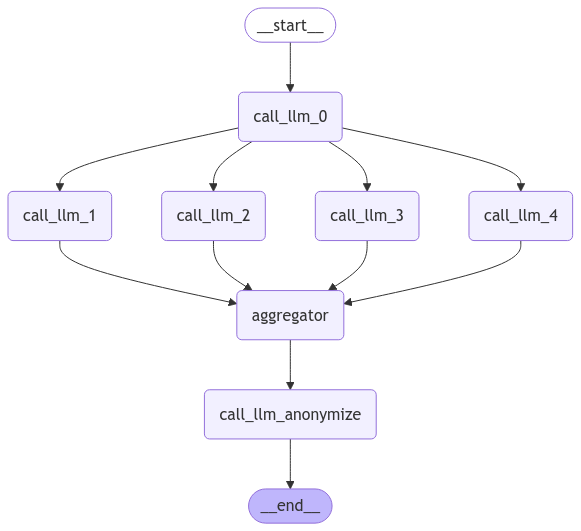

In [6]:
# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [7]:
# Invoke
USER_REQUEST = "please, could you analyze the provided file doc1.pdf?"

# call must be formatted this way
state = parallel_workflow.invoke({"request": USER_REQUEST})

# display the final, aggregated and anonymized, result
display(Markdown((state["final_output"])))

2025-02-11 17:35:52,397 - Calling llm_0...
2025-02-11 17:35:52,974 - File name to be analyzed is: doc1.pdf
2025-02-11 17:35:52,976 - Reading file content...
2025-02-11 17:35:53,319 - Calling llm_1 to identify spelling errors...
2025-02-11 17:35:53,320 - Calling llm_3 to analyze goals...
2025-02-11 17:35:53,320 - Calling llm_2 to analyze clarity...
2025-02-11 17:35:53,320 - Calling llm_4 to summarize...
2025-02-11 17:36:01,864 - Aggregating outputs...
2025-02-11 17:36:01,867 - Calling llm_anonymize to anonymize text...


## Analysis of the document: doc1.pdf

### Summary:
Here is a summary of the text in one page:

**Proof of Concept Joint Execution Plan**

**Overview**

Oracle and [CLIENT] have agreed to collaborate on a Proof of Concept (POC) to assess [CLIENT]'s environment requirements and deliver a set of architecture recommendations using Oracle Cloud technology. The goal is to migrate [CLIENT]'s workload from AWS to Oracle Cloud Infrastructure (OCI) and improve efficiencies.

**Scope and Approach**

The POC will focus on the following areas:

* Creating an OCI account and configuring tenancy
* Setting up a Kubernetes cluster
* Configuring resource manager and installing customer stack applications
* Configuring Gen AI and Data Science services

**Timelines**

The POC will be completed in 10 weeks, with the following phases:

1. Setting up an OCI environment (1 week)
2. Configuring networking, virtual machines, and storage (2 weeks)
3. Configuring monitoring and logging (2 weeks)
4. Configuring Data Science and Gen AI (2 weeks)
5. Installing customer applications and testing (2 weeks)
6. POC conclusion and go-live (1 week)

**Deliverables**

The POC will deliver a production-level working environment that supports [CLIENT]'s product launches using OCI.

**Success Criteria**

The POC will be considered successful if it meets the following criteria:

* Ease of deployment
* Performance
* Ability to use Data Science services and receive good results

**Contacts**

The POC team includes representatives from [CLIENT] and Oracle, with [REPRESENTATIVE 1] as the Cloud Sales rep and [REPRESENTATIVE 2] as the ACE lead.

### Clarity:
I would give this text a score of 6 out of 10 in terms of clarity. Here's why:

Strengths:

1. **Clear structure**: The document has a clear table of contents, and the sections are well-organized and easy to follow.
2. **Specific details**: The text provides specific details about the project, such as the timeline, scope, and deliverables.
3. **Technical terms**: The document uses technical terms and acronyms (e.g., OCI, IAAS, PaaS, OKE) that are likely familiar to the target audience.

Weaknesses:

1. **Complexity**: The text assumes a high level of technical knowledge and may be difficult for non-experts to understand.
2. **Lengthy sentences**: Some sentences are long and convoluted, making them hard to follow.
3. **Lack of concise summaries**: The document could benefit from brief summaries or overviews of each section to help readers quickly understand the main points.
4. **Typos and formatting issues**: There are a few typos (e.g., "effeciencies" instead of "efficiencies") and formatting issues (e.g., inconsistent spacing between sections).
5. **Redundancy**: Some information, such as the project timeline, is repeated in different sections, which can make the document feel repetitive.

To improve clarity, I would suggest:

1. **Simplifying sentence structure**: Break up long sentences into shorter, more manageable ones.
2. **Adding concise summaries**: Provide brief summaries or overviews of each section to help readers quickly understand the main points.
3. **Defining technical terms**: Consider adding a glossary or defining technical terms and acronyms for readers who may not be familiar with them.
4. **Editing for typos and formatting**: Carefully proofread the document to eliminate typos and formatting issues.
5. **Removing redundancy**: Eliminate repetitive information and focus on providing a clear, concise narrative.

### Goals:
The provided text is a Joint Execution Plan for a Proof of Concept (POC) between Oracle and [CLIENT]. Here's an evaluation of the document:

**Clear and Measurable Goals:**
The document defines specific, measurable, achievable, relevant, and time-bound (SMART) goals for the POC. These goals include:

1. Improving scanning quality by at least 10%
2. Enhancing policy ranking tools
3. Migrating [CLIENT]'s workload from AWS to OCI
4. Demonstrating the ease of deployment, performance, and scalability of the OCI environment

The document also outlines specific deliverables, such as a production-level working environment that supports [CLIENT]'s product launches.

**Score:**
I would give this document a score of 8 out of 10. The document provides a clear overview of the POC, its objectives, and the approach to be taken. It also defines specific timelines, milestones, and responsibilities. However, there are a few areas that could be improved:

1. Some sections, such as the "Use Case(s)" section, are not fully defined or contain errors (e.g., "Error! Bookmark not defined.").
2. The document could benefit from more detailed information on the technical requirements and specifications for the POC.
3. There is no explicit section on risk management or contingency planning, which is an important aspect of any project plan.

Overall, the document provides a good foundation for the POC, but could be improved with more attention to detail and additional information on technical requirements and risk management.

### Spelling errors:
Here are the top 10 spelling errors found in the text:

1. "effeciencies" (should be "efficiencies") - found on page 3
2. "scannig" (should be "scanning") - found on page 4
3. "repo" (should be "repository") - found on page 5 (although "repo" is a common abbreviation, it's not clear if it's intended to be a formal term in this context)
4. "ballancers" (should be "load balancers") - found on page 5
5. "Gen AI" (should be "General AI" or "Generative AI", depending on the context) - found on multiple pages
6. "Data Science and integration with third party software to support Hebrew" (should be "Data Science and integration with third-party software to support the Hebrew language") - found on page 5
7. "4st" (should be "4th") - found on page 5
8. "assess its environment requirements and deliver a set of architecture recommendations with a roadmap, and a business case that demonstrates how Oracle Cloud aligns with the [CLIENT]" (should be "assess its environment requirements and deliver a set of architecture recommendations with a roadmap and a business case that demonstrates how Oracle Cloud aligns with [CLIENT]'s") - found on page 3 (missing possessive apostrophe)
9. "use data science service and receive good results from other insurances companies by 10% (including Hebrew)" (should be "use the data science service and receive good results from other insurance companies by 10%, including those that support the Hebrew language") - found on page 6
10. "ACE" (should be "ACE (Architecture, Cloud, and Engineering)" or a similar expansion, depending on the context) - found on multiple pages (although "ACE" is likely an abbreviation, it's not clear what it stands for without further context)

Note that some of these errors may be minor or context-dependent, and some may be intentional uses of abbreviations or technical terms.